In [159]:
import sys
import glob
import os
import re
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.ticker as mtick
from pylab import rcParams
%matplotlib inline

In [160]:
rcParams['figure.figsize'] = 11, 4

In [195]:
# read dataset and perform data conversion
df = pd.read_csv('15000x8.2.log', usecols=["hotcache", "instance", "name", "selectivity", "duration_ns"])
df["duration_sec"] = df["duration_ns"] / 1000000000
del df["duration_ns"]
df = df.groupby(["hotcache", "name", "selectivity"]).agg({'duration_sec': np.mean})

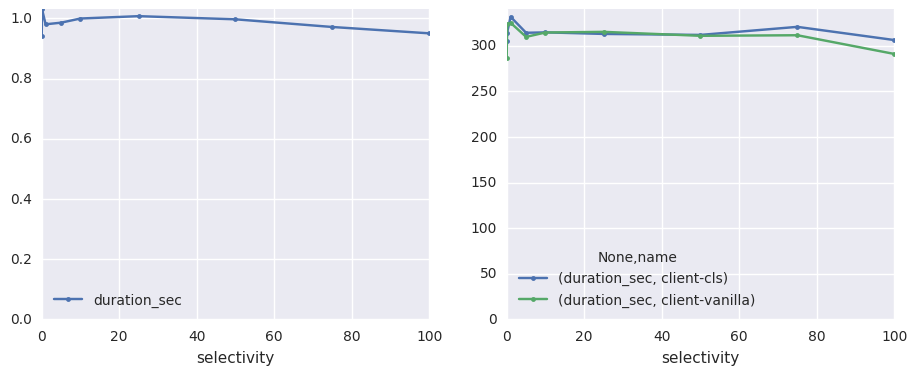

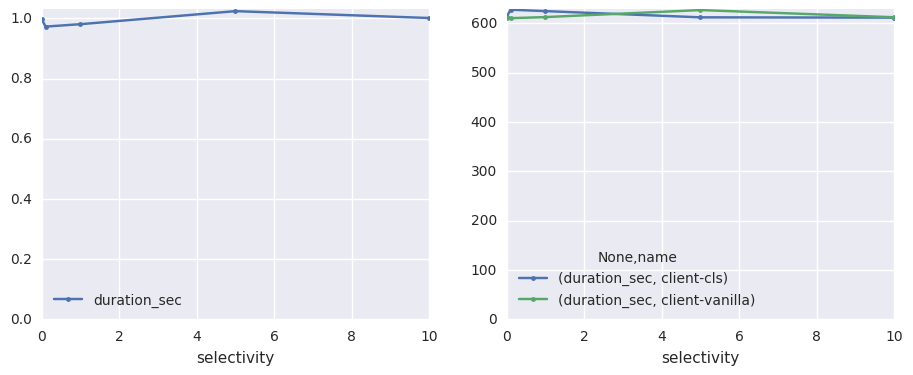

In [196]:
# sanity check baseline in which the client performs all filtering.
# the goal here is just ensure that the baseline we are using doesn't have
# any unexpected overheads.
#
#   1. rados.read interface
#   2. rados.exec interface (bulk read through object class)
#
def plot_baselines(df):
    fig, ax = plt.subplots(1, 2)
    speedup = df.loc["client-vanilla"].div(df.loc["client-cls"], level="selectivity")
    speedup.plot(ax=ax[0], marker=".")
    ax[0].set_ylim(bottom=0)
    #ax[0].set_ylim(bottom=-.1, top=.1)
    duration = df.loc[["client-vanilla", "client-cls"]].unstack(level=0)
    duration.plot(ax=ax[1], marker='.')
    ax[1].set_ylim(bottom=0)
plot_baselines(df.loc[True])
plot_baselines(df.loc[False])

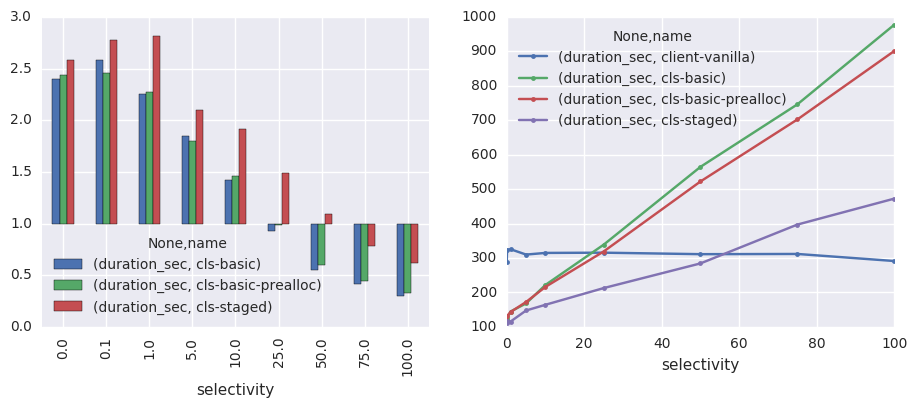

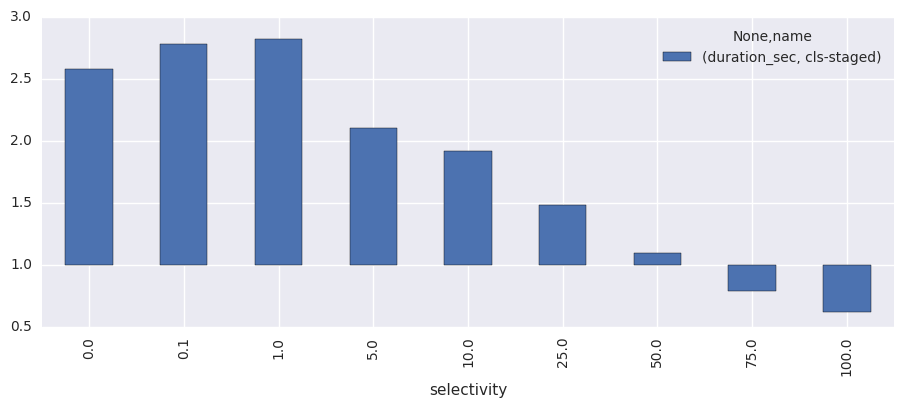

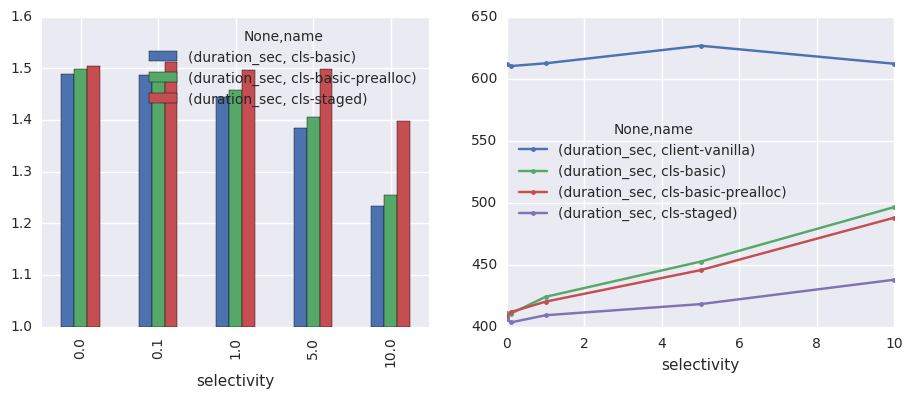

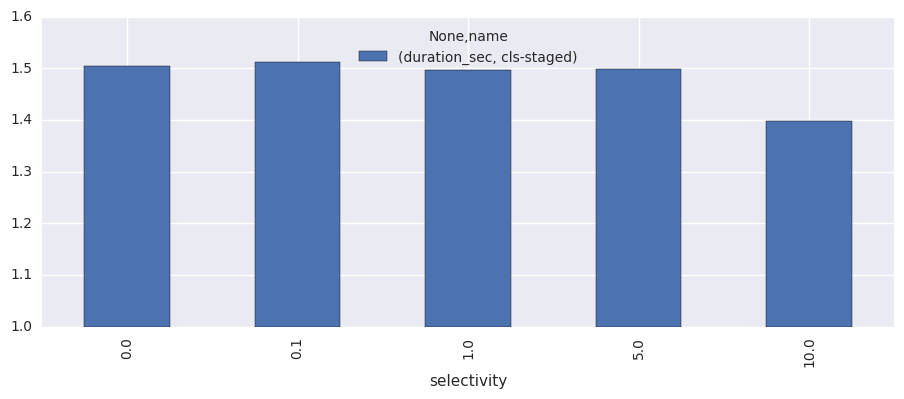

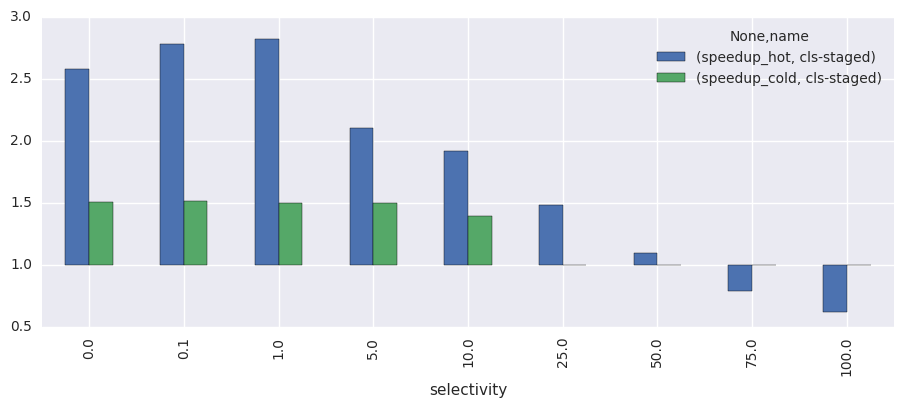

In [197]:
# plot the speedup/benefit of performing filtering in the object class
#   1. cls-basic appends each matching row to a bufferlist
#   2. cls-basic-prealloc is the same as (1) but pre-allocates the bufferlist
#   3. cls-staged stages matching rows in a stack-allocated array and appends to bufferlist
def plot_cls_filtering(df):
    fig, ax = plt.subplots(1, 2)
    baseline = df.loc["client-vanilla"]
    speedup = 1.0 / df.div(baseline, level="selectivity") - 1.0
    speedup.loc[["cls-basic", "cls-basic-prealloc", "cls-staged"]].unstack(level=0).plot.bar(ax=ax[0])
    ax[0].yaxis.set_major_formatter(mtick.FuncFormatter(lambda x,_: x + 1.0))
    df.loc[["cls-basic", "cls-basic-prealloc", "cls-staged", "client-vanilla"]].unstack(level=0).plot(ax=ax[1], marker='.')
    fig, ax = plt.subplots(1)
    speedup.loc[["cls-staged"]].unstack(level=0).plot.bar(ax=ax)
    ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x,_: x + 1.0))
    
def plot_cls_filtering_hc(hot, cold):
    fig, ax = plt.subplots(1)
    baseline_hot = hot.loc["client-vanilla"]
    speedup_hot = 1.0 / hot.div(baseline_hot, level="selectivity") - 1.0
    baseline_cold = cold.loc["client-vanilla"]
    speedup_cold = 1.0 / cold.div(baseline_cold, level="selectivity") - 1.0
    
    speedup_hot.columns = ["speedup_hot"]
    speedup_cold.columns = ["speedup_cold"]
    speedup = pd.concat([speedup_hot, speedup_cold], axis=1)
    speedup.loc[["cls-staged"]].unstack(level=0).plot.bar(ax=ax)
    
    ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x,_: x + 1.0))
    
plot_cls_filtering(df.loc[True])
plot_cls_filtering(df.loc[False])
plot_cls_filtering_hc(df.loc[True], df.loc[False])

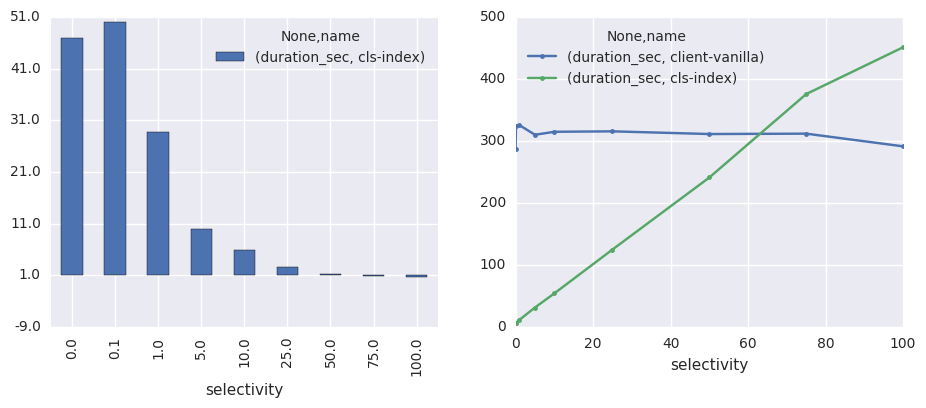

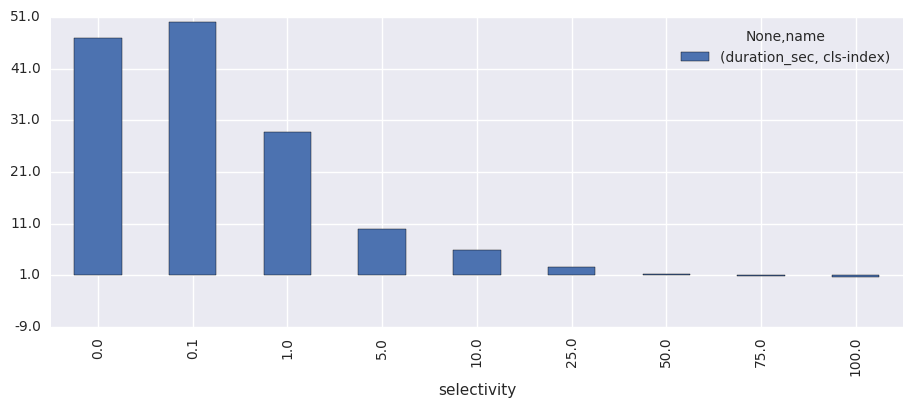

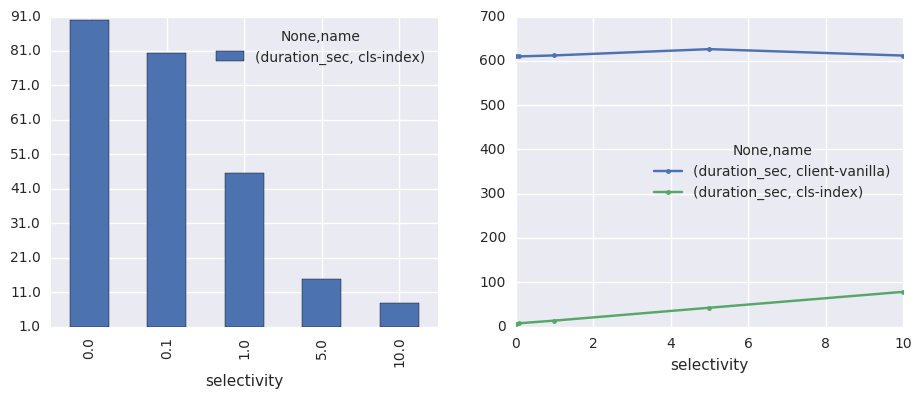

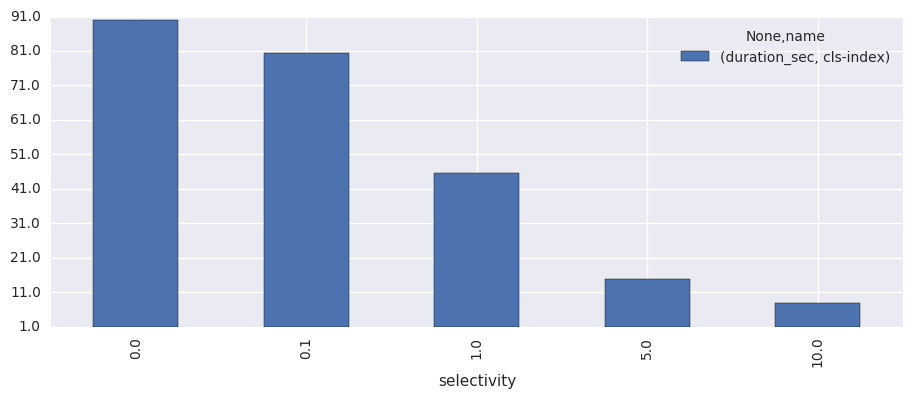

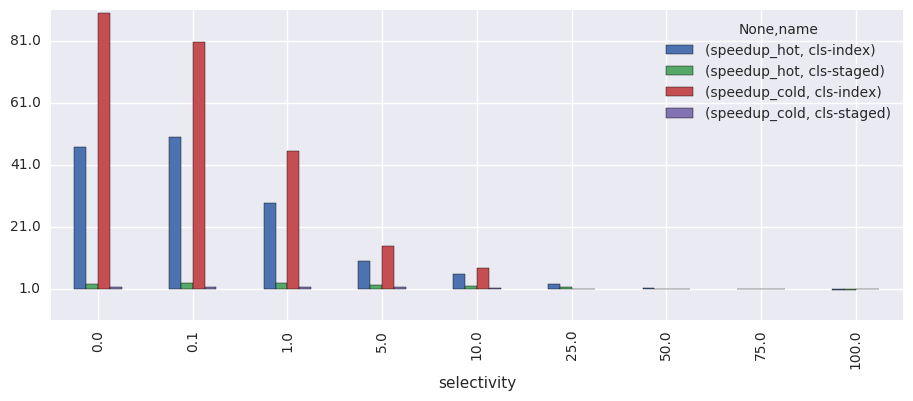

In [199]:
def plot_cls_filtering_with_indexing(df):
    fig, ax = plt.subplots(1, 2)
    baseline = df.loc["client-vanilla"]
    speedup = 1.0 / df.div(baseline, level="selectivity") - 1.0
    speedup.loc[["cls-index"]].unstack(level=0).plot.bar(ax=ax[0])
    ax[0].yaxis.set_major_formatter(mtick.FuncFormatter(lambda x,_: x + 1.0))
    df.loc[["cls-index", "client-vanilla"]].unstack(level=0).plot(ax=ax[1], marker='.')
    fig, ax = plt.subplots(1)
    speedup.loc[["cls-index"]].unstack(level=0).plot.bar(ax=ax)
    ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x,_: x + 1.0))
    
def plot_cls_filtering_with_indexing_hc(hot, cold):
    fig, ax = plt.subplots(1)
    baseline_hot = hot.loc["client-vanilla"]
    speedup_hot = 1.0 / hot.div(baseline_hot, level="selectivity") - 1.0
    baseline_cold = cold.loc["client-vanilla"]
    speedup_cold = 1.0 / cold.div(baseline_cold, level="selectivity") - 1.0

    speedup_hot.columns = ["speedup_hot"]
    speedup_cold.columns = ["speedup_cold"]
    speedup = pd.concat([speedup_hot, speedup_cold], axis=1)
    speedup.loc[["cls-staged", "cls-index"]].unstack(level=0).plot.bar(ax=ax)
    #ax.set_yscale("log")
    ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x,_: x + 1.0))
    
plot_cls_filtering_with_indexing(df.loc[True])
plot_cls_filtering_with_indexing(df.loc[False])
plot_cls_filtering_with_indexing_hc(df.loc[True], df.loc[False])

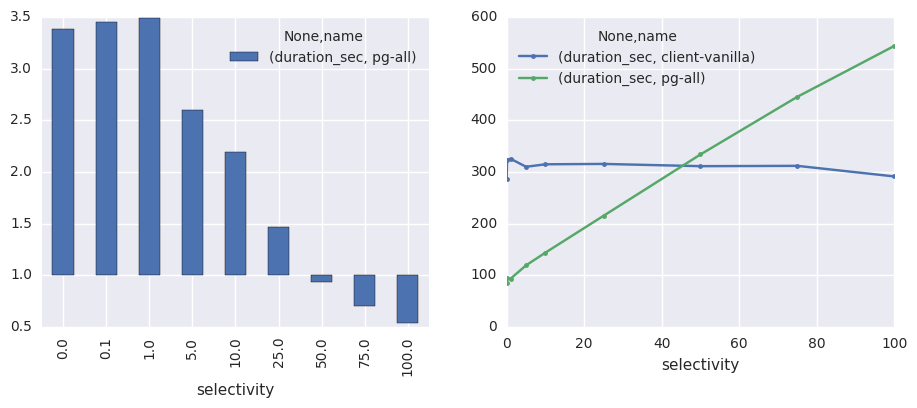

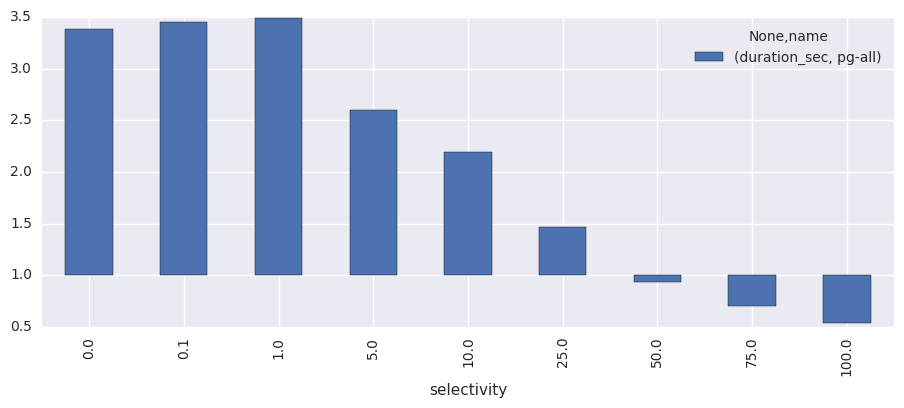

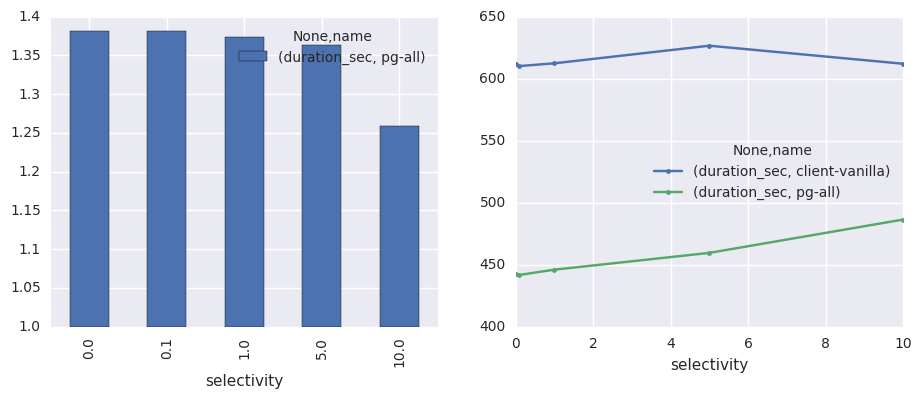

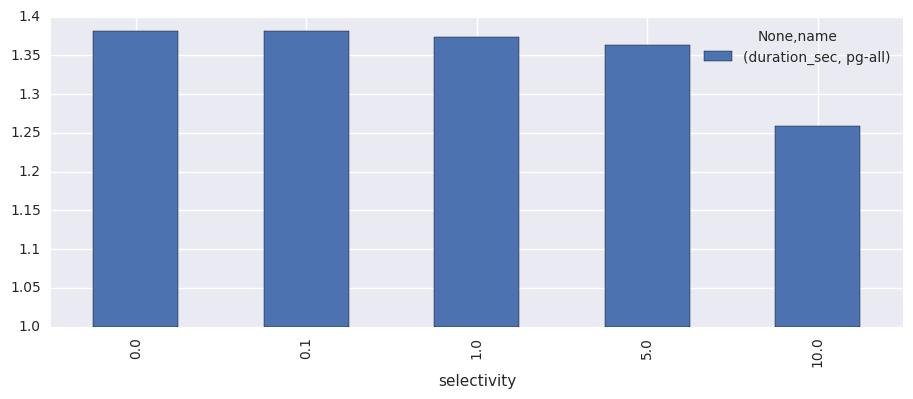

In [200]:
def plot_pg_filtering(df):
    fig, ax = plt.subplots(1, 2)
    baseline = df.loc["client-vanilla"]
    speedup = 1.0 / df.div(baseline, level="selectivity") - 1.0
    speedup.loc[["pg-all"]].unstack(level=0).plot.bar(ax=ax[0])
    ax[0].yaxis.set_major_formatter(mtick.FuncFormatter(lambda x,_: x + 1.0))
    df.loc[["pg-all", "client-vanilla"]].unstack(level=0).plot(ax=ax[1], marker='.')
    fig, ax = plt.subplots(1)
    speedup.loc[["pg-all"]].unstack(level=0).plot.bar(ax=ax)
    ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x,_: x + 1.0))
plot_pg_filtering(df.loc[True])
plot_pg_filtering(df.loc[False])

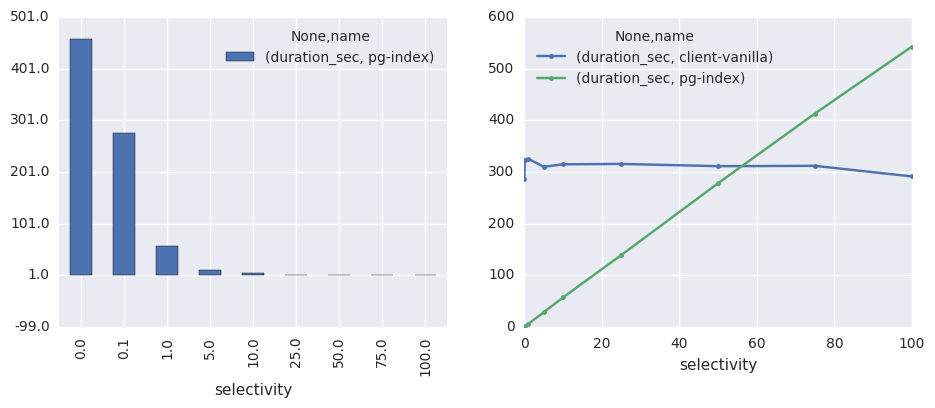

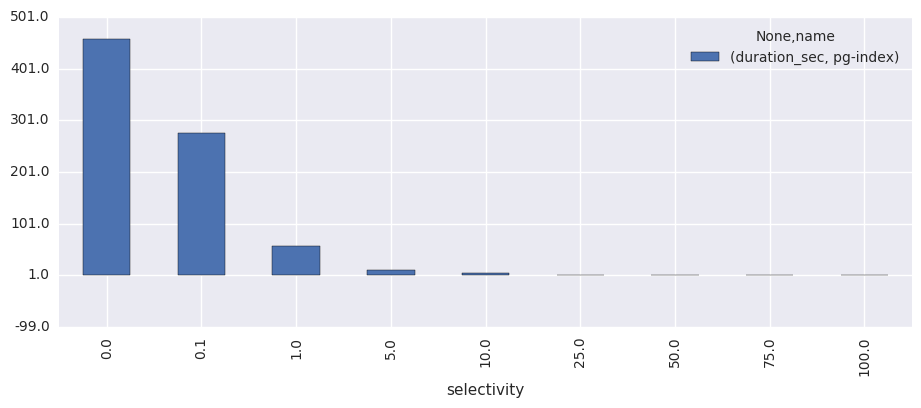

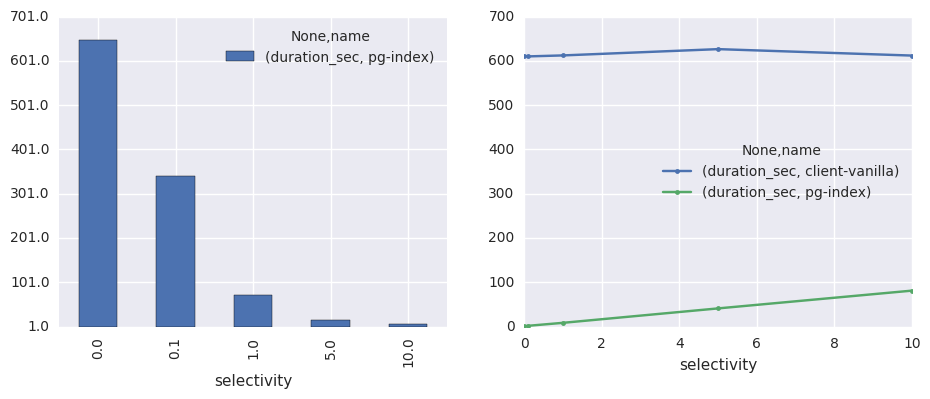

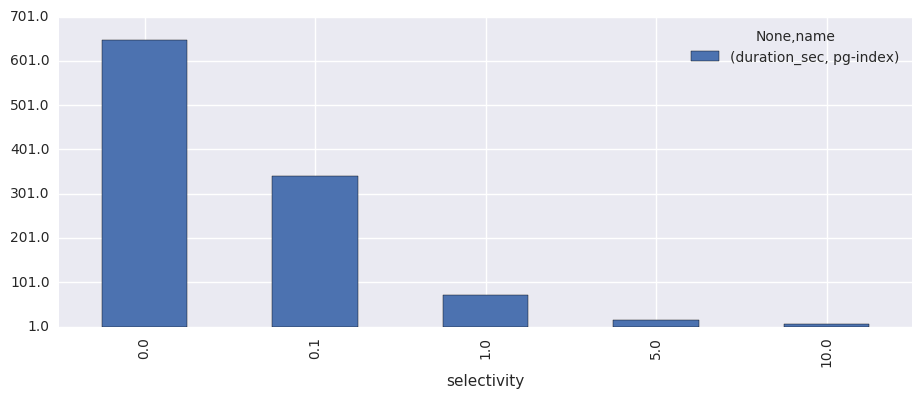

In [201]:
def plot_pg_filtering_with_index(df):
    fig, ax = plt.subplots(1, 2)
    baseline = df.loc["client-vanilla"]
    #baseline = df.loc["cls-index"]
    speedup = 1.0 / df.div(baseline, level="selectivity") - 1.0
    speedup.loc[["pg-index"]].unstack(level=0).plot.bar(ax=ax[0])
    ax[0].yaxis.set_major_formatter(mtick.FuncFormatter(lambda x,_: x + 1.0))
    df.loc[["pg-index", "client-vanilla"]].unstack(level=0).plot(ax=ax[1], marker='.')
    #df.loc[["pg-index", "cls-index"]].unstack(level=0).plot(ax=ax[1], marker='.')
    fig, ax = plt.subplots(1)
    speedup.loc[["pg-index"]].unstack(level=0).plot.bar(ax=ax)
    ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x,_: x + 1.0))
plot_pg_filtering_with_index(df.loc[True])
plot_pg_filtering_with_index(df.loc[False])